<a href="https://colab.research.google.com/github/traitortots/will-it-ADU/blob/main/Sorting_Polygon_Sides.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install shapely geopandas pyproj

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 84.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 67.5 MB/s eta 0:00:00


In [2]:
from shapely.geometry import Polygon, LineString, MultiLineString, Point, MultiPoint, MultiPolygon
from shapely.geometry.base import BaseGeometry
from shapely.strtree import STRtree
from shapely.ops import linemerge, unary_union, nearest_points, polygonize
from shapely.affinity import translate, rotate
import math
import geopandas as gpd
from geopandas import GeoDataFrame
import pandas as pd
import matplotlib.pyplot as plt
from pyproj import Transformer
import pyproj
import numpy as np
from typing import List, Tuple
import traceback
from typing import List, Union, Optional, Tuple, Any

# Functions

In [3]:
def explode_line(poly: Polygon) -> List[LineString]:
    """A function to return all segments of a line as a list of linestrings"""
    coords = poly.exterior.coords  # Create a list of all line node coordinates
    parts = []
    for part in zip(coords, coords[1:]):  # For each start and end coordinate pair
        parts.append(LineString(part))  # Create a linestring and append to parts list
    return parts

# Function to calculate rhumb bearing between two points
Coordinate = Union[Tuple[float, float], List[float]]

def calculate_rhumb_bearing(
    pt1: Coordinate,
    pt2: Coordinate,
    source_crs: Union[str, pyproj.CRS] = "EPSG:2906"
) -> float:
    geod = pyproj.Geod(ellps="WGS84")

    # Create a transformer to convert from the source CRS to EPSG:4326
    transformer = Transformer.from_crs(source_crs, "EPSG:4326")

    # Transform the coordinates to latitude and longitude
    lon1, lat1 = transformer.transform(pt1[1], pt1[0])
    lon2, lat2 = transformer.transform(pt2[1], pt2[0])

    angle, reverse_angle, distance = geod.inv(lon1, lat1, lon2, lat2)

    # Normalize the angle to the range -180 to 180
    bearing = (angle + 180) % 360 - 180
    return bearing

In [4]:
def assign_bearing(bearing, reference):
    m1 = min(
        abs(reference[0] - bearing),
        bearing <= reference[0] and
        (180 - reference[0]) + bearing or
        (180 - bearing) + reference[0])
    m2 = min(
        abs(reference[1] - bearing),
        bearing <= reference[1] and
        (180 - reference[1]) + bearing or
        (180 - bearing) + reference[1])
    return 0 if abs(m1) <= abs(m2) else 1


def compare_bearings(convex_hull_lines, bounding_box_lines):
    # Calculate the bearings of the two possible bounding box lines
    bounding_box_bearings = [calculate_rhumb_bearing(line.coords[0], line.coords[1]) for line in bounding_box_lines][:2]

    # Initialize empty lists for lines closer to each bearing
    closer_to_bearing_1 = []
    closer_to_bearing_2 = []

    # Iterate over each line in the convex hull
    for line in convex_hull_lines:
        # Calculate the bearing of the line
        line_bearing = calculate_rhumb_bearing(line.coords[0], line.coords[1])

        # Assign the line to a group based on its bearing relative to the two possible bounding box bearings
        group = assign_bearing(line_bearing, bounding_box_bearings)
        if group == 0:
            closer_to_bearing_1.append(line)
        else:
            closer_to_bearing_2.append(line)

    return closer_to_bearing_1, closer_to_bearing_2


# Test

In [5]:
# Load the geojson file into a GeoDataFrame
parcels_gdf = gpd.read_file("/content/drive/MyDrive/Cornell/Exit Project/Parcels_Public.geojson")

# Reproject the GeoDataFrame to EPSG:2906 in place
parcels_gdf = parcels_gdf.to_crs(epsg=2906)

In [6]:
# Set the unique ID of the parcel you want to extract
parcel_id = 3641

# Get the polygon for the specified parcel ID
polygon = parcels_gdf.loc[parcels_gdf['FID'] == parcel_id, 'geometry'].iloc[0]

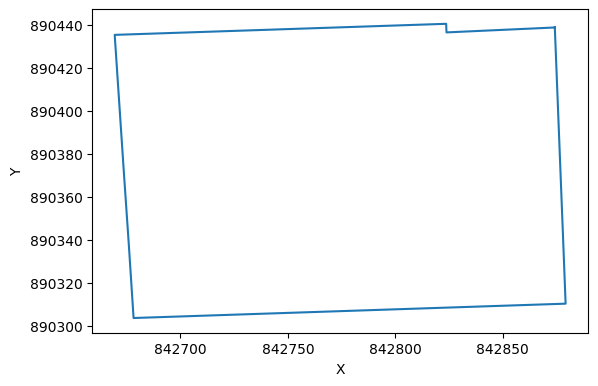

In [7]:
# Extract x and y coordinates from the polygon
x, y = polygon.exterior.coords.xy

# Create a plot with matplotlib
fig, ax = plt.subplots()

# Plot the polygon
ax.plot(x, y)

# Set aspect ratio to equal
ax.set_aspect('equal')

# Add labels for x and y axis
ax.set_xlabel('X')
ax.set_ylabel('Y')

# Show the plot
plt.show()

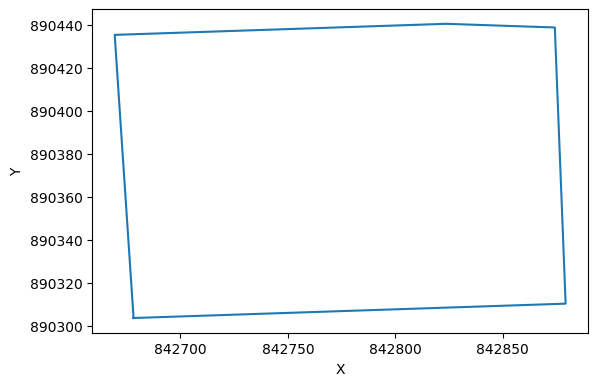

In [8]:
# Create a convex hull from the polygon
convex_hull = polygon.convex_hull

# Extract x and y coordinates from the convex hull
x, y = convex_hull.exterior.coords.xy

# Create a new plot with matplotlib
fig, ax = plt.subplots()

# Plot the convex hull
ax.plot(x, y)

# Set aspect ratio to equal
ax.set_aspect('equal')

# Add labels for x and y axis
ax.set_xlabel('X')
ax.set_ylabel('Y')

# Show the plot
plt.show()

convex_hull_lines: [<LINESTRING (842678.222 890303.512, 842669.443 890435.22)>, <LINESTRING (842669.443 890435.22, 842823.628 890440.367)>, <LINESTRING (842823.628 890440.367, 842874.171 890438.657)>, <LINESTRING (842874.171 890438.657, 842877.89 890343.88)>, <LINESTRING (842877.89 890343.88, 842879.191 890310.185)>, <LINESTRING (842879.191 890310.185, 842678.222 890303.512)>]
convex_hull_bearings: [-0.7012155267708238, 78.27603555586143, 99.9401804494442, 179.57460516831873, 179.58102116071325, -101.66862141804671]


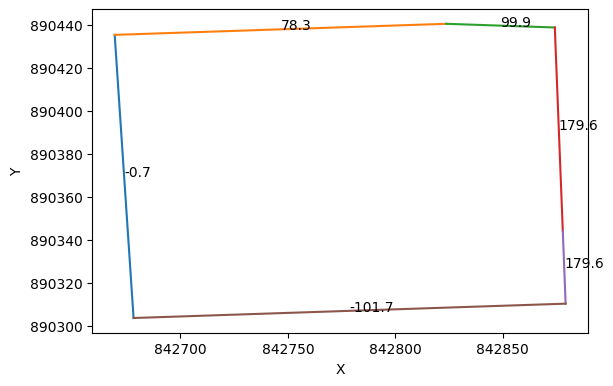

In [9]:
convex_hull_lines = explode_line(convex_hull)
print("convex_hull_lines:", convex_hull_lines)

convex_hull_bearings = [calculate_rhumb_bearing(line.coords[0], line.coords[1]) for line in convex_hull_lines]
print("convex_hull_bearings:", convex_hull_bearings)

# Create a new plot with matplotlib
fig, ax = plt.subplots()

# Plot each line string in the convex hull and its midpoint with bearing text
for line, bearing in zip(convex_hull_lines, convex_hull_bearings):
    x, y = line.coords.xy
    ax.plot(x, y)
    midx, midy = line.centroid.coords.xy
    ax.text(midx[0], midy[0], f"{bearing:.1f}")

# Set aspect ratio to equal
ax.set_aspect('equal')

# Add labels for x and y axis
ax.set_xlabel('X')
ax.set_ylabel('Y')

# Show the plot
plt.show()

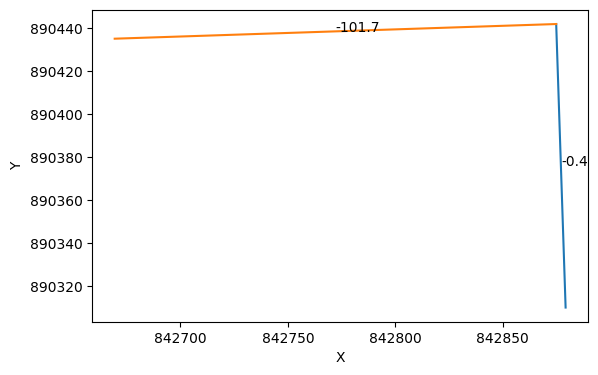

[-0.3646610264992205, -101.67002035928186]


In [10]:
# Get the minimum bounding rectangle of the polygon
bounding_box = polygon.minimum_rotated_rectangle

# Split the bounding box into individual LineString objects
bounding_box_lines = explode_line(bounding_box)

# Calculate the bearings of each line
bounding_box_bearings = [calculate_rhumb_bearing(line.coords[0], line.coords[1]) for line in bounding_box_lines][:2]

# Create a new plot with matplotlib
fig, ax = plt.subplots()

# Plot each line string in the bounding box and its midpoint with bearing text
for line, bearing in zip(bounding_box_lines, bounding_box_bearings):
    x, y = line.coords.xy
    ax.plot(x, y)
    midx, midy = line.centroid.coords.xy
    ax.text(midx[0], midy[0], f"{bearing:.1f}")

# Set aspect ratio to equal
ax.set_aspect('equal')

# Add labels for x and y axis
ax.set_xlabel('X')
ax.set_ylabel('Y')

# Show the plot
plt.show()

print(bounding_box_bearings)

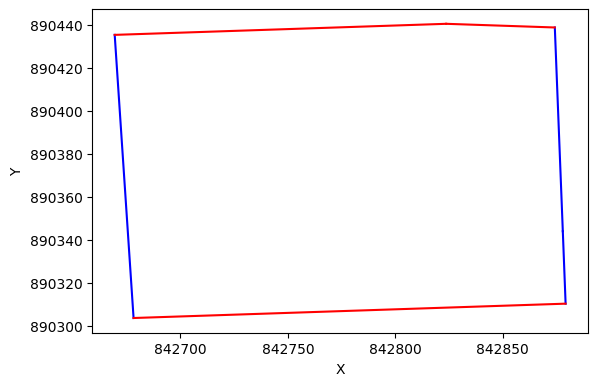

bbox bearings [-0.3646610264992205, -101.67002035928186]
convex hull bearings [-0.7012155267708238, 78.27603555586143, 99.9401804494442, 179.57460516831873, 179.58102116071325, -101.66862141804671]
closer to bearing 1 [<LINESTRING (842678.222 890303.512, 842669.443 890435.22)>, <LINESTRING (842874.171 890438.657, 842877.89 890343.88)>, <LINESTRING (842877.89 890343.88, 842879.191 890310.185)>]
closer to bearing 2 [<LINESTRING (842669.443 890435.22, 842823.628 890440.367)>, <LINESTRING (842823.628 890440.367, 842874.171 890438.657)>, <LINESTRING (842879.191 890310.185, 842678.222 890303.512)>]


In [11]:
# Compare the bearings of the convex hull lines to the bounding box lines
closer_to_bearing_1, closer_to_bearing_2 = compare_bearings(convex_hull_lines, bounding_box_lines)

# Plot the lines closer to each bearing in different colors
fig, ax = plt.subplots()

# Plot lines closer to first bounding box bearing in blue
for line in closer_to_bearing_1:
    x, y = line.coords.xy
    ax.plot(x, y, 'b')

# Plot lines closer to second bounding box bearing in red
for line in closer_to_bearing_2:
    x, y = line.coords.xy
    ax.plot(x, y, 'r')

# Set aspect ratio to equal
ax.set_aspect('equal')

# Add labels for x and y axis
ax.set_xlabel('X')
ax.set_ylabel('Y')

# Show the plot
plt.show()

print("bbox bearings", bounding_box_bearings)
print("convex hull bearings", convex_hull_bearings)
print("closer to bearing 1", closer_to_bearing_1)
print("closer to bearing 2", closer_to_bearing_2)

In [ ]:
print("bbox bearings", bounding_box_bearings)
print("convex hull bearings", convex_hull_bearings)

bbox bearings [179.53268001668744, 75.17492317015899]
convex hull bearings [-19.508008607287053, -0.4436715489740948, 75.17393735472353, -176.88552731020525]
